# Quantum Machine Learning in Julia with Amazon Braket

## 0. Setup

Install pre-requisites required for this notebook to run

In [26]:
using Pkg;
#Pkg.add("Plots");
#Pkg.add("PyPlot");
#Pkg.add("PyCall");
#Pkg.add("AWS");
#Pkg.add("Colors");
#Pkg.build("PyCall");
#Pkg.add("Flux");
#Pkg.add("MLDatasets");
#Pkg.add("Optim"); #TODO: Keep one or the other
#Pkg.add("NLopt");
#Pkg.add("ProgressMeter");

Import all the required libraries

In [27]:
using PyCall
using Statistics: mean
using AWS: @service
@service S3;
@service Braket;
@service STS;
using MLDatasets
using Colors
using Plots
using Flux: onehotbatch, onecold, onehot;
using Flux.Data: DataLoader
using Flux;
using NLopt;
using ProgressMeter;

# Braket imports
awsbraket = pyimport("braket.aws");
devices   = pyimport("braket.devices");
circuit   = pyimport("braket.circuits");

We are going to use the LocalSimulator to run this notebook, so that we don't incur any cost.

In [28]:
qpu = devices.LocalSimulator();

## 1. Quantum Neural Networks (QNN)

The following example has been adapted from \[[1](https://aws.amazon.com/blogs/quantum-computing/aioi-using-quantum-machine-learning-with-amazon-braket-to-create-a-binary-classifier/)\]

In machine learning, binary classification is a supervised learning task where the labels can take one of two values. For instance, given a dataset of images of food, a binary classification problem can be useful in detecting whether an image is of a hot dog or not.

![https://tinyurl.com/hotdog-classification](assets/hotdog.png "Quanvolutional Neural Networks")

A machine learning model to solve a binary classification problem needs four components:

**A collection of data points:** The data along with the ground-truth labels for each datapoint. In our hot-dog example, the data would be a collection of images and their ground-truth labels would be whether they are images of hot-dogs.

**Objective function:** Tells us how accurate/inaccurate the model is from the correct solution for a particular set of datapoints.

**Trainable parameters:** A set of weights that can be applied to the model. The model uses these weights combined with the data to make a decision

**An optimization routine:** For a given set of trainable parameters, the optimization routine tells us how to change the trainable parameters to minimize the objective function. 

In classical machine learning, there are several options for each of the aforementioned components.


**Quantum Machine Learning** in near term quantum devices can refer to any one of the following scenarios

![Schuld, Maria, and Francesco Petruccione. Supervised learning with quantum computers. Vol. 17. Berlin: Springer, 2018.](assets/landscape.png "Quantum Machine Learning Landscape")



**CC:** Classical data processed by Classical algorithms


**CQ:** Classical data processed by Quantum algorithms


**QC:** Quantum data processed by Classical algorithms


**QQ:** Quantum data processed by Quantum algorithms


In this notebook, we will explore the **CQ** scenario of clasical data processed by quantum algorithms. We will use the binary classification problem of parity detection. A bitstring $x_i$, has even parity if it has an even number of 1 bits and odd parity if it has an odd number of 1 bits.


### 1.1 Generate Data

The function below computes the parity of a given bit string.

In [29]:
function parity(bitStr)
    return count(i->(i=='1'), bitStr) % 2
end;

println("Bit string: 1011 | Parity: ", parity("1011"))
println("Bit string: 1001 | Parity: ", parity("1001"))

Bit string: 1011 | Parity: 1
Bit string: 1001 | Parity: 0


To generate data, we will take all bit strings of size $n$ and label them as $0$ if they have an even parity and $1$ if they have odd parity. We use ~70% of the data for training and ~30% of the data for testing.

In [62]:
nBits = 5;

trainSet = []
testSet = []

trainLabel = []
testLabel = []

for ind in 1:2^nBits-1
    if rand() < 0.30
        bitStr = join(string.(digits(ind, base=2, pad=nBits)))
        push!(testSet, bitStr)
        push!(testLabel, parity(bitStr))
    else
        bitStr = join(string.(digits(ind, base=2, pad=nBits)))
        push!(trainSet, bitStr)
        push!(trainLabel, parity(bitStr))
    end;
end;

Let's sample a few data points from the training set

In [63]:
for i in 1:5
    ind = rand(1:length(trainSet))
    println("Data: ", trainSet[ind], " | Label: ", trainLabel[ind])
end

Data: 10010 | Label: 0
Data: 00010 | Label: 1
Data: 00010 | Label: 1
Data: 10110 | Label: 1
Data: 00010 | Label: 1


### 1.2 Circuits as Models

In classical machine learning, we have several choices for what model we can use (Regression, SVM, Neural Networks etc.). However, they can mostly be broken down into learning a set of parameters that can be combined with the data to generate the outcome we want. The learned parameters work in the most optimal setting and generate predictions that are closest to the data distribution.

|  |  |
| --- | --- |
| ![](assets/perceptron.jpg "The perceptron") | ![](assets/theta-landscape.png "Parameter Landscape") |

Similarly, variational quantum circuits with a set of classical parameters $W$ can be used to make predictions for a given dataset. By finding the most optimal parameters $W$ we can improve the performance of the model.

However, we first need to map our classical bitstring into quantum states. We map classical bit values 0 and 1 onto quantum states |0〉 and |1〉, respectively. 

By convention, the initial state of a qubit is always assumed to be |0〉. If a quantum algorithm requires the input quantum state to be |1〉, then we obtain it from |0〉by applying a qubit flip gate $X$ 

$$|1〉 = X |0〉$$ 

Below we provide code that generates a quantum circuit for preparing an arbitrary multi-qubit computational basis state |$\psi_i$ 〉using the Amazon Braket SDK. Unlike Julia, the Braket SDK uses 0 based qubit indexing. Although not strictly necessary, we add identity gates for indices with 0 in the bitstring.

In [32]:
function bit_string_to_circuit(bitStr)
    circ = circuit.Circuit()
    
    for i=firstindex(bitStr):lastindex(bitStr)
        if bitStr[i] == '1'
            circ.add(circuit.Circuit().x(i-1))
        else
            circ.add(circuit.Circuit().i(i-1))
        end
    end
    
    return circ
end;

We can visualize how our function converted the bit string by using the Amazon Braket SDK's diagram function:

In [33]:
println(bit_string_to_circuit("111000111").diagram())

T  : |0|
        
q0 : -X-
        
q1 : -X-
        
q2 : -X-
        
q3 : -I-
        
q4 : -I-
        
q5 : -I-
        
q6 : -X-
        
q7 : -X-
        
q8 : -X-

T  : |0|


For our parity detection example, we will use a quantum circuit with $N+1$ qubits. The $N$ bit bitstring is encoded in the first $N$ qubits labelled $\{0, N-1\}$. The $(N+1)^{th}$ qubit labelled $N$ is used to store the output binary label assigned to the bitstring. We first apply the RY gate to the first $N$ qubits and the $RX$ gate to the $(N+1)^{th}$ qubit. The XX rotation gate is applied to each qubit with the ${0, N}$ qubits as the control qubits and the $(N+1)^{th}$ qubit as the target qubit. We then consider the angles for each of the rotation gates in the circuit as optimization parameters. 

![M Fischer, D Brooks, P Lougovski, and T Takeshita - 2021](assets/qml_parity.jpg "Quantum Neural Network")

The code below implements this QNN, applies it to an arbitrary input state defined by a classical bit string, and measures the values of the label qubit.

In [34]:
function QNN(bitStr, pars)
    nQbts = length(bitStr)
    qnn = circuit.Circuit()
    qnn.add(circuit.Circuit().rx(nQbts, pars[1]))
    for i = 1:length(bitStr)
        angles = pars[2 * (i - 1) + 1:2 * (i - 1) + 1 + 2]
        if bitStr[i] == '1'
            qnn.add(circuit.Circuit().x(i - 1))
        end
        qnn.add(circuit.Circuit().ry(i - 1, angles[2]))
        if i <= nQbts
            qnn.add(circuit.Circuit().xx(i - 1, nQbts, angles[3]))
        end
    end
    observZ = circuit.Observable.Z()
    return qnn.add(circuit.Circuit().expectation(observZ, target=[nQbts]))
end;

Let's apply random parameters to the QNN with a bit string of length 4.

In [35]:
sampleNBits = 4
value = "1010"
weights = 1:(sampleNBits * 2 + 1)
circ = QNN(value, weights)
println(circ.diagram())

T  : |  0  |  1  |  2  |  3  |  4  |  5  | Result Types |
                                                         
q0 : -X-----Ry(2)-XX(3)----------------------------------
                  |                                      
q1 : -Ry(4)-------|-----XX(5)----------------------------
                  |     |                                
q2 : -X-----Ry(6)-|-----|-----XX(7)----------------------
                  |     |     |                          
q3 : -Ry(8)-------|-----|-----|-----XX(9)----------------
                  |     |     |     |                    
q4 : -Rx(1)-------XX(3)-XX(5)-XX(7)-XX(9)-Expectation(Z)-

T  : |  0  |  1  |  2  |  3  |  4  |  5  | Result Types |


To generate a prediction from the QNN, we can define a utility function

In [39]:
function predict(bitStr, params)
    qpu = devices.LocalSimulator()
    circ = QNN(bitStr, params)

    activation = qpu.run(circ, shots=0).result().values[1]
    
    return 0 + ((1 - activation) / 2 > 0.5)
end;

We can try out this utility function with a random bitstring and random weights.

In [46]:
nBits = 4
value = "1011"
weights = rand(-pi:pi,(4*2+1))
println("Model predicted: ", predict(value, weights), " | ", "Actual Parity: ", parity(value))

Model predicted: 0 | Actual Parity: 1


### 1.3 The Objective Function

We use the mean-square error as a metric to identify how far off we are from the ideal solution. The mean square error is:

$$
MSE(Y, \hat{Y}) = \frac{\Sigma_{i=0}^N y_i - \hat{y}_i}{N}
$$


In [47]:
function square_loss(labels, predictions)
    loss = 0
    
    for (i, label) in enumerate(labels)
        loss+=(labels[i] - predictions[i])^2
    end
    
    return loss/length(labels)[1]
end;


The cost function defined below computes the mean squared error for the entire training data

In [48]:
function cost(var, features, labels)
    preds = []
    for feature in features
        prediction = predict(feature, var)
        push!(preds,prediction)
    end;
    lossVal = square_loss(labels, preds)
    
    return lossVal
end;

### 1.5 The Parameter Shift Rule

The parameter-shift rule states that, given a variational quantum circuit $U(\boldsymbol{\theta})$ composed of parametrized Pauli rotations, and some measured observable $\hat{B}$, the derivative of the expectation value

$$
\langle\hat{B}\rangle(\boldsymbol{\theta})=\left\langle 0\left|U(\boldsymbol{\theta})^{\dagger} \hat{B} U(\boldsymbol{\theta})\right| 0\right\rangle
$$

with respect to the input circuit parameters $\theta$ is given by

$$
\nabla_{\theta_{i}}\langle\hat{B}\rangle(\boldsymbol{\theta})=\frac{1}{2}\left[\langle\hat{B}\rangle\left(\boldsymbol{\theta}+\frac{\pi}{2} \hat{\mathbf{e}}_{i}\right)-\langle\hat{B}\rangle\left(\boldsymbol{\theta}-\frac{\pi}{2} \hat{\mathbf{e}}_{i}\right)\right]
$$

Thus, the gradient of the expectation value can be calculated by evaluating the same variational quantum circuit, but with shifted parameter values \[[2](https://pennylane.ai/qml/demos/tutorial_backprop.html)\]

In [49]:
function parameter_shift_term(dataset, labels, params, i)
    shifted = copy(params)
    
    shifted[i] += pi/2
    plus = cost(shifted, dataset, labels)
    
    shifted[i] -= pi
    minus = cost(shifted, dataset, labels)
    
    return 0.5 * (plus - minus)
end;

In [50]:
function parameter_shift(dataset, labels, params)
    gradients = zeros(size(params)[1])
    
    for i in 1:size(params)[1]
        gradients[i] = parameter_shift_term(dataset, labels, params, i)
    end;
    
    return gradients;
end;

### 1.6 Training the Quantum Neural Network

Now that we have a way to get the direction in which the parameters need to be updated, we can use gradient descent to perform the actual optimization

In [51]:
opt = Descent(0.01); # Gradient descent with learning rate 0.1
W = rand(-pi:pi, nBits * 2 + 1);
trainingLoss = []

In [54]:
epochs = 100;
@showprogress for i in 1:epochs
    Flux.Optimise.update!(opt, W, parameter_shift(trainSet, trainLabel, W))
    push!(trainingLoss, cost(W, trainSet, trainLabel))
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


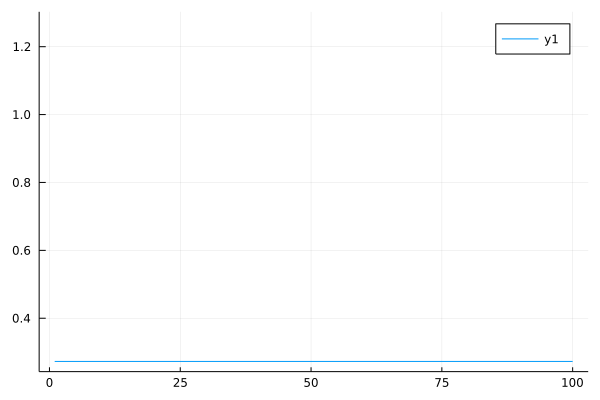

In [55]:
plot(trainingLoss)

### 1.7 Testing the QNN

In [61]:
for (ind, data) in enumerate(trainSet)
    prediction = predict(data, W)
    println("Feature:", data, "| QNN predicted parity: ", prediction, " | ", "Actual Parity: ", parity(data))
    println("---------------------------------------------------")
end
cost(W, trainSet, testLabel)

Feature:0100| QNN predicted parity: 1 | Actual Parity: 1
---------------------------------------------------
Feature:1100| QNN predicted parity: 0 | Actual Parity: 0
---------------------------------------------------
Feature:0110| QNN predicted parity: 1 | Actual Parity: 0
---------------------------------------------------
Feature:1110| QNN predicted parity: 0 | Actual Parity: 1
---------------------------------------------------
Feature:0001| QNN predicted parity: 1 | Actual Parity: 1
---------------------------------------------------
Feature:1001| QNN predicted parity: 0 | Actual Parity: 0
---------------------------------------------------
Feature:0101| QNN predicted parity: 0 | Actual Parity: 0
---------------------------------------------------
Feature:1101| QNN predicted parity: 1 | Actual Parity: 1
---------------------------------------------------
Feature:1011| QNN predicted parity: 0 | Actual Parity: 1
---------------------------------------------------
Feature:0111| QNN p

0.5

## 2. References

\[1\] [Using Quantum Machine Learning with Amazon Braket to Create a Binary Classifier](https://aws.amazon.com/blogs/quantum-computing/aioi-using-quantum-machine-learning-with-amazon-braket-to-create-a-binary-classifier/)

\[2\] [Quantum gradients with backpropagation](https://pennylane.ai/qml/demos/tutorial_backprop.html)

\[3\] [Training](https://fluxml.ai/Flux.jl/stable/training/training/)

\[4\] [Quantum Computing Learning Series 10: Training a Quantum Circuit](https://broadcast.amazon.com/videos/307498)

\[5\] [Automatic Differentiation of Quantum Circuits](https://www.youtube.com/watch?v=McgBeSVIGus)

\[6\] [Introduction to Quantum Machine Learning with PennyLane](https://www.youtube.com/playlist?list=PL_hJxz_HrXxsQNJHWp10up8x-hwd5uwr0)